In [1]:
import pandas as pd
from os import listdir
import numpy as np
# import feather

In [2]:
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import phate

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

from sklearn.metrics.cluster import adjusted_rand_score

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#PREPROCESSING:

In [4]:
temp = pd.read_feather('sample_var_phenos_leuk_topmed_v2.feather').set_index('sampleID').drop(columns=[
                                                                                                'CHIP_Gene', 
                                                                                                'AD', 
                                                                                                'AgeAt_All_Pneumonia', 
                                                                                                'AF', 
                                                                                                'Incd_Hypertension', 
                                                                                                'id'])

In [5]:
#Check NAN values in all phenotypes:
i = -63
for nan  in temp.isna().sum().to_list()[-63:]:
    print(temp.columns[i], nan) #nan counts
    i += 1
    
del i

Sex_numeric 0
age 0
SmokingStatus 0
ever_smoked 0
age2 0
PC1 53
PC2 53
PC3 53
PC4 53
PC5 53
PC6 53
PC7 53
PC8 53
PC9 53
PC10 53
Coronary_Artery_Disease_SOFT 0
Prev_Coronary_Artery_Disease_SOFT 1079
Incd_Coronary_Artery_Disease_SOFT 2041
Coronary_Artery_Disease_SOFT_FollowUp 0
Death 0
Prev_Death 713
Incd_Death 0
Death_FollowUp 0
Diabetes_All 0
Prev_Diabetes_All 605
Incd_Diabetes_All 1955
Diabetes_All_FollowUp 0
Diabetes_Type_1 0
Prev_Diabetes_Type_1 82
Incd_Diabetes_Type_1 165
Diabetes_Type_1_FollowUp 0
Diabetes_Type_2 0
Prev_Diabetes_Type_2 962
Incd_Diabetes_Type_2 865
Diabetes_Type_2_FollowUp 0
Heart_Failure 19
Prev_Heart_Failure 285
Incd_Heart_Failure 217
Heart_Failure_FollowUp 19
Hypercholesterolemia 0
Prev_Hypercholesterolemia 1977
Incd_Hypercholesterolemia 5537
Hypercholesterolemia_FollowUp 0
Hypertension 0
Prev_Hypertension 2031
Hypertension_FollowUp 0
hasCHIP 0
AML 1
Prev_AML 1
Incd_AML 21
AML_FollowUp 1
MPN 1
Prev_MPN 1
Incd_MPN 37
MPN_FollowUp 1
Platelet count 1100
Platelet cr

In [5]:
temp = temp.drop(columns=[
    'age',
    'age2',
    'PC1',
    'PC2',
    'PC3',
    'PC4',
    'PC5',
    'PC6',
    'PC7',
    'PC8',
    'PC9',
    'PC10',
    'Prev_Coronary_Artery_Disease_SOFT',
    'Incd_Coronary_Artery_Disease_SOFT',
    'Coronary_Artery_Disease_SOFT_FollowUp',
    'Death',
    'Prev_Death',
    'Incd_Death',
    'Death_FollowUp',
    'Diabetes_All',
    'Prev_Diabetes_All',
    'Incd_Diabetes_All',
    'Diabetes_All_FollowUp',
    'Prev_Diabetes_Type_1',
    'Incd_Diabetes_Type_1',
    'Diabetes_Type_1_FollowUp',
    'Prev_Diabetes_Type_2',
    'Incd_Diabetes_Type_2',
    'Diabetes_Type_2_FollowUp',
    'Prev_Heart_Failure',
    'Incd_Heart_Failure',
    'Heart_Failure_FollowUp',
    'Prev_Hypercholesterolemia',
    'Incd_Hypercholesterolemia',
    'Hypercholesterolemia_FollowUp',
    'Prev_Hypertension',
    'Hypertension_FollowUp',
    'Prev_AML',
    'Incd_AML',
    'AML_FollowUp',
    'Prev_MPN',
    'Incd_MPN',
    'MPN_FollowUp',
    'Incd_All_Pneumonia',
    'All_Pneumonia_FollowUp',
    'Prev_All_Pneumonia',
    'Platelet count',
    'Platelet crit',
    'Mean platelet volume',
    'Platelet distribution width']).dropna()

In [6]:
phenotypes = temp[[
                    'Hypercholesterolemia',
                    'Hypertension',
                    'hasCHIP',
                    'AML',
                    'MPN',
                    'All_Pneumonia',
                    'Sex_numeric',
                    'SmokingStatus',
                    'ever_smoked',
                    'Coronary_Artery_Disease_SOFT',
                    'Diabetes_Type_1',
                    'Diabetes_Type_2',
                    'Heart_Failure']]
data = temp.drop(columns=[
                            'Hypercholesterolemia',
                            'Hypertension',
                            'hasCHIP',
                            'AML',
                            'MPN',
                            'All_Pneumonia',
                            'Sex_numeric',
                            'SmokingStatus',
                            'ever_smoked',
                            'Coronary_Artery_Disease_SOFT',
                            'Diabetes_Type_1',
                            'Diabetes_Type_2',
                            'Heart_Failure'])
del temp

In [5]:
len(data.columns)

196555

In [ ]:
#VISUALISATION:

In [7]:
#PCA with data normalization
#not using phenotypes for my clustering methods, instead using them as labels
scaler = StandardScaler()
scaler.fit(data)

X_train_scaled = scaler.transform(data)

pca_scaled = PCA()

X_pca_scaled = pca_scaled.fit_transform(X_train_scaled)

In [ ]:
#Adjust number of PCs used in the future analyses according to this graph:
plt.plot(np.cumsum(pca_scaled.explained_variance_ratio_))

In [ ]:
#Plot PC0 vs PC1 -- can play with other PCs:
for phenotype in phenotypes.columns:
    plt.figure()
    plt.scatter(X_pca_scaled[:, 0], X_pca_scaled[:, 1], c=phenotypes[phenotype], s=100, alpha=.4) #s = size, alpha = transparency 
    plt.xlabel(phenotype + " PCA feature 0")
    plt.ylabel("PCA feature 1")
    # Show/save figure as desired.
    plt.show()
# Can show all four figures at once by calling plt.show() here, outside the loop.
#plt.show()

In [ ]:
#If necessary, use only a portion of the data:
# reduced_pca = np.vstack((X_pca_scaled[phenotypes.hasCHIP == 1], X_pca_scaled[phenotypes.hasCHIP == 0][0:9000,:]))
# reduced_pca_notsc = np.vstack((X_pca[phenotypes.hasCHIP == 1], X_pca[phenotypes.hasCHIP == 0][0:9000,:]))
#replace data.hasCHIP by phenotype of interest and adjust 9000 to some other number

In [ ]:
#T-SNE:
tsne = TSNE(random_state=42, n_components=2, n_jobs=-1)
tsne_data = tsne.fit_transform(X_pca_scaled[:, 0:1900])#adjust '1900' according to the # of PCs you are using; use reduced_pca[:, 0:1900] instead if using only a slice of the data

In [ ]:
for phenotype in phenotypes.data:
    plt.figure(figsize=(10, 10))
    plt.xlim(tsne_data[:, 0].min(), tsne_data[:, 0].max() + 1) #decrease '1' if the graph looks empty
    plt.ylim(tsne_data[:, 1].min(), tsne_data[:, 1].max() + 1)

    plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=phenotypes[phenotype]) #s = size, alpha = transparency 
    plt.xlabel(phenotype + " t-SNE feature 0")
    plt.ylabel("t-SNE feature 1")
    # Show/save figure as desired.
    plt.show()
# Can show all four figures at once by calling plt.show() here, outside the loop.
#plt.show()

In [8]:
#UMAP
import umap
reducer = umap.UMAP(random_state=42)
reducer.fit(X_pca_scaled[:, 0:1900]) #adjust the num of PCs according to the variance covered#T-SNE:#adjust '1900' according to the # of PCs you are using; use reduced_pca[:, 0:1900] instead if using only a slice of the data
embedding = reducer.transform(X_pca_scaled[:, 0:1900]) #adjust '1900' according to the # of PCs you are using; use reduced_pca[:, 0:1900] instead if using only a slice of the data

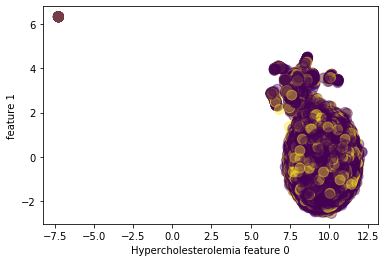

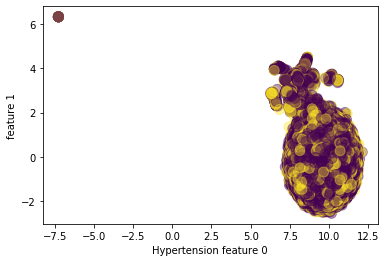

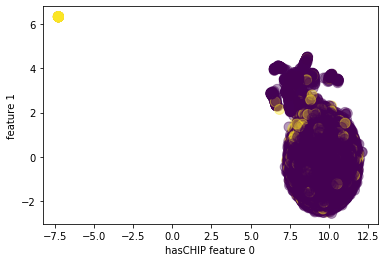

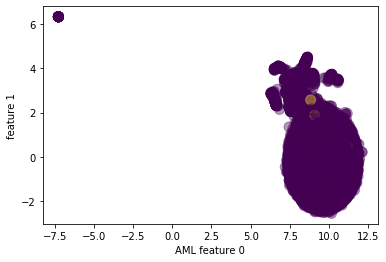

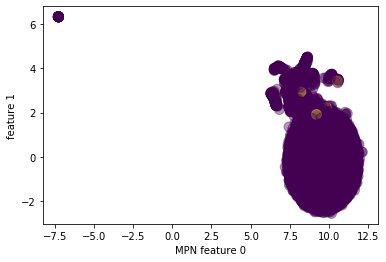

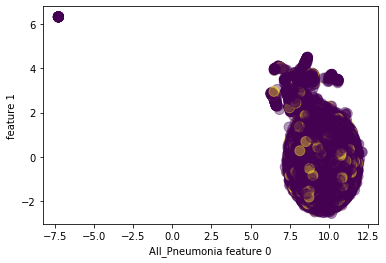

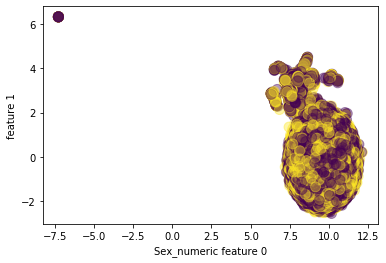

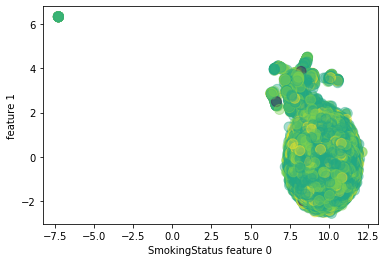

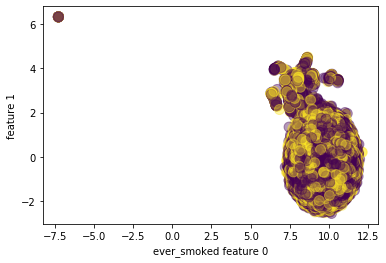

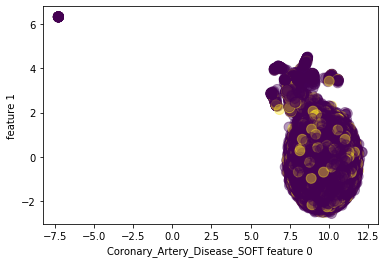

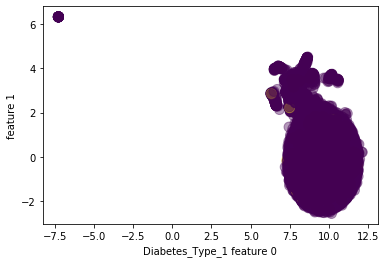

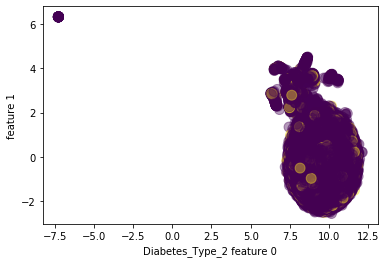

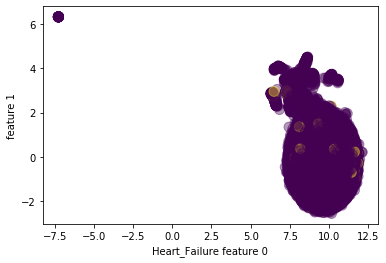

In [9]:
for phenotype in phenotypes.columns:
    plt.figure()
    plt.scatter(embedding[:, 0], embedding[:, 1], c=phenotypes[phenotype], s=100, alpha=.4)
    plt.xlabel(phenotype + " feature 0")
    plt.ylabel("feature 1")
    # Show/save figure as desired.
    plt.show()
# Can show all four figures at once by calling plt.show() here, outside the loop.
#plt.show()

In [10]:
#PHATE:
phate_op = phate.PHATE(n_pca=1900, n_jobs=-1) #adjust the num of PCs according to the variance covered#T-SNE:
data_phate = phate_op.fit_transform(data)

Calculating PHATE...
  Running PHATE on 38050 observations and 2548 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 50.55 seconds.
    Calculating KNN search...
    Calculated KNN search in 696.65 seconds.
    Calculating affinities...


/opt/anaconda3/lib/python3.7/site-packages/graphtools/graphs.py:293: RuntimeWarning: Detected zero distance between 1253699 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  RuntimeWarning,
/opt/anaconda3/lib/python3.7/site-packages/graphtools/graphs.py:451: RuntimeWarning: overflow encountered in power
  K.data = np.exp(-1 * np.power(K.data, self.decay))


    Calculated affinities in 3667.51 seconds.
  Calculated graph and diffusion operator in 6834.36 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2244.58 seconds.
    Calculating KMeans...
    Calculated KMeans in 230.98 seconds.
  Calculated landmark operator in 2572.86 seconds.
  Calculating optimal t...
    Automatically selected t = 3
  Calculated optimal t in 0.05 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 0.12 seconds.
Calculated PHATE in 9407.48 seconds.


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) scatter2d. (Use scprep.plot.scatter2d instead) -- Deprecated since version 1.0.0.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) scatter2d. (Use scprep.plot.scatter2d instead) -- Deprecated since version 1.0.0.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) scatter2d. (Use scprep.plot.scatter2d instead) -- Deprecated since version 1.0.0.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) scatter2d. (Use scprep.plot.scatter2d instead) -- Deprecated since version 1.0.0.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or stat

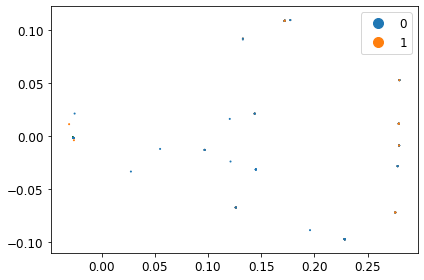

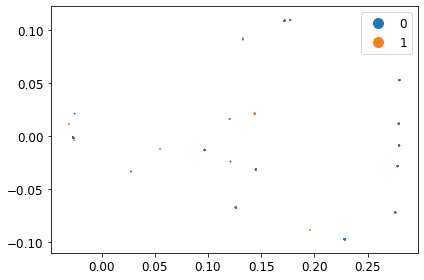

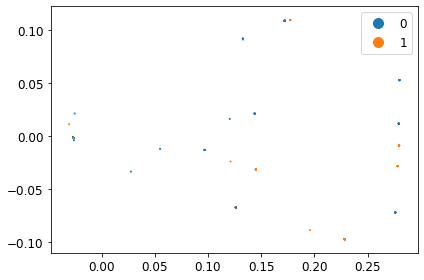

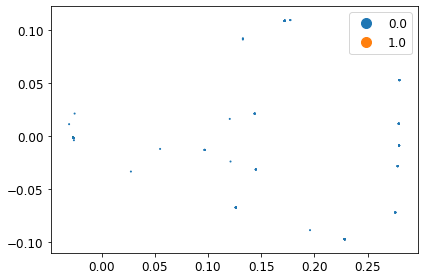

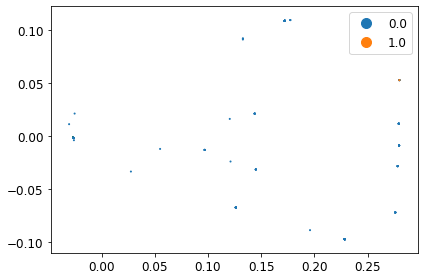

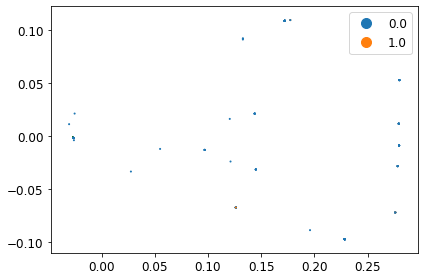

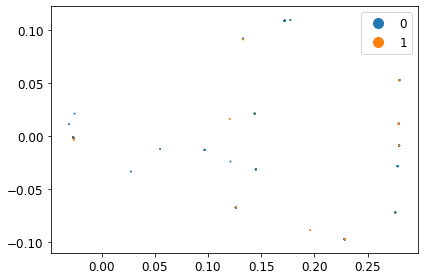

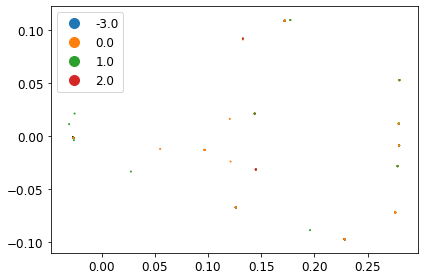

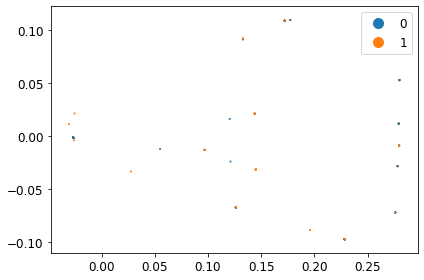

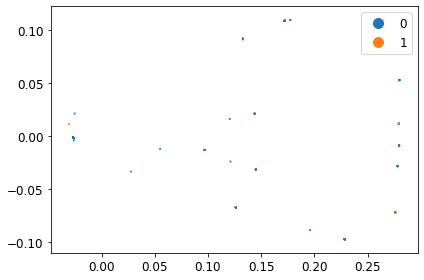

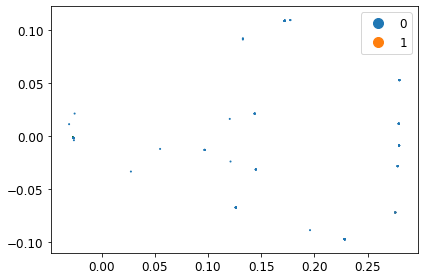

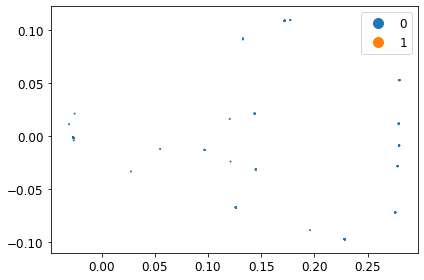

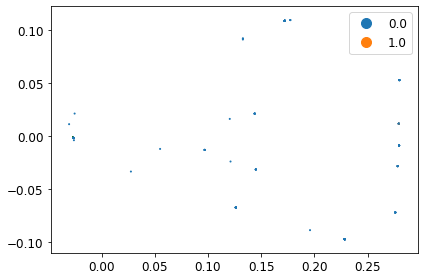

In [11]:
for phenotype in phenotypes:
    phate.plot.scatter2d(data_phate, c=phenotypes[phenotype])

In [ ]:
#CLUSTERING

In [31]:
#Kmeans:
kmeans = KMeans(n_jobs=-1) #can play with n_clusters= and max_iter=; default is 8 and 300 respectively
kmeans.fit(X_pca_scaled[:, 0:1900]) #adjust 1900 to number of PCs#T-SNE:

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [32]:
(unique, counts) = np.unique(kmeans.labels_, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[    0, 38038],
       [    1,     1],
       [    2,     1],
       [    3,     1],
       [    4,     1],
       [    5,     1],
       [    6,     4],
       [    7,     3]])

In [ ]:
#Agglomerative-Ward
agg = AgglomerativeClustering() #can play with (e.g., n_clusters=2); default is 8
assignment = agg.fit_predict(X_pca_scaled[:, 0:1900]) #adjust 1900 to number of PCs#T-SNE:

In [ ]:
(unique, counts) = np.unique(assignment, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

In [ ]:
#Agglomerative-Complete
agg = AgglomerativeClustering(linkage="complete") #can play with (e.g., n_clusters=2); default is 8
assignment = agg.fit_predict(X_pca_scaled[:, 0:1900]) #adjust 1900 to number of PCs#T-SNE:

In [ ]:
(unique, counts) = np.unique(assignment, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

In [ ]:
#Agglomerative-Average
agg = AgglomerativeClustering(linkage="average") #can play with (e.g., n_clusters=2); default is 8
assignment = agg.fit_predict(X_pca_scaled[:, 0:1900]) #adjust 1900 to number of PCs#T-SNE:

In [ ]:
(unique, counts) = np.unique(assignment, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

In [ ]:
#DBSCAN:
dbscan = DBSCAN()
clusters = dbscan.fit_predict(X_pca_scaled[:, 0:1900]) #adjust '1900' according to the # of PCs you are using; use reduced_pca[:, 0:1900] instead if using only a slice of the data

In [ ]:
(unique, counts) = np.unique(clusters, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

KMeans; Hypercholesterolemia=0.00
KMeans; Hypertension=-0.00
KMeans; AML=-0.00
KMeans; Hypertension=-0.00
KMeans; MPN=-0.00
KMeans; All_Pneumonia=-0.00
KMeans; SmokingStatus=-0.00
KMeans; Coronary_Artery_Disease_SOFT=-0.00
KMeans; Diabetes_Type_1=-0.00
KMeans; Diabetes_Type_2=-0.00
KMeans; Heart_Failure=-0.00
AgglomerativeClustering; Hypercholesterolemia=-0.00
AgglomerativeClustering; Hypertension=0.00
AgglomerativeClustering; AML=-0.00
AgglomerativeClustering; Hypertension=0.00
AgglomerativeClustering; MPN=-0.00
AgglomerativeClustering; All_Pneumonia=-0.00
AgglomerativeClustering; SmokingStatus=-0.00
AgglomerativeClustering; Coronary_Artery_Disease_SOFT=-0.00
AgglomerativeClustering; Diabetes_Type_1=-0.00
AgglomerativeClustering; Diabetes_Type_2=-0.00
AgglomerativeClustering; Heart_Failure=-0.00
AgglomerativeClustering; Hypercholesterolemia=-0.00
AgglomerativeClustering; Hypertension=0.00
AgglomerativeClustering; AML=-0.00
AgglomerativeClustering; Hypertension=0.00
AgglomerativeCluste

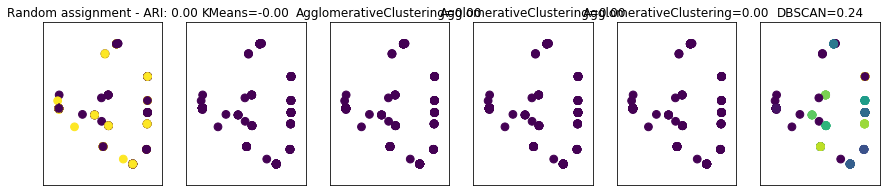

In [12]:
#COMPARE CLUSTERING ALGOS:
fig, axes = plt.subplots(1, 6, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# make a list of algorithms to use
algorithms = [KMeans(n_jobs=-1, n_clusters=2), 
              AgglomerativeClustering(n_clusters=2), 
              AgglomerativeClustering(n_clusters=2, linkage="complete"),
              AgglomerativeClustering(n_clusters=2, linkage="average"),
              DBSCAN()]

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(data))

# plot random assignment
axes[0].scatter(data_phate[:, 0], data_phate[:, 1], c=random_clusters, s=60)#use the best vis. techniq (e.g, UMAP, PHATE, t-sne instead of PCs)
axes[0].set_title("Random assignment - ARI: {:.2f}".format(adjusted_rand_score(phenotypes.hasCHIP == 1, random_clusters)))

for ax, algorithm in zip(axes[1:], algorithms):
    # plot the cluster assignments and cluster centers
    clusters = algorithm.fit_predict(X_pca_scaled[:, 0:1900])#adjust '1900' according to the # of PCs you are using; use reduced_pca[:, 0:1900] instead if using only a slice of the data
    ax.scatter(data_phate[:, 0], data_phate[:, 1], c=clusters, s=1)#use the best vis. techniq (e.g, UMAP, PHATE, t-sne instead of PCs)
    ax.set_title("{}={:.2f}".format(algorithm.__class__.__name__, adjusted_rand_score(phenotypes.hasCHIP == 1, clusters)))
    
    print("{}; Hypercholesterolemia={:.2f}".format(algorithm.__class__.__name__, adjusted_rand_score(phenotypes.Hypercholesterolemia == 1, clusters)))    
    print("{}; Hypertension={:.2f}".format(algorithm.__class__.__name__, adjusted_rand_score(phenotypes.Hypertension == 1, clusters)))
    print("{}; AML={:.2f}".format(algorithm.__class__.__name__, adjusted_rand_score(phenotypes.AML == 1, clusters)))
    print("{}; Hypertension={:.2f}".format(algorithm.__class__.__name__, adjusted_rand_score(phenotypes.Hypertension == 1, clusters)))
    print("{}; MPN={:.2f}".format(algorithm.__class__.__name__, adjusted_rand_score(phenotypes.MPN == 1, clusters)))
    print("{}; All_Pneumonia={:.2f}".format(algorithm.__class__.__name__, adjusted_rand_score(phenotypes.All_Pneumonia == 1, clusters)))
    print("{}; SmokingStatus={:.2f}".format(algorithm.__class__.__name__, adjusted_rand_score(phenotypes.SmokingStatus == 1, clusters)))
    print("{}; Coronary_Artery_Disease_SOFT={:.2f}".format(algorithm.__class__.__name__, adjusted_rand_score(phenotypes.Coronary_Artery_Disease_SOFT == 1, clusters)))
    print("{}; Diabetes_Type_1={:.2f}".format(algorithm.__class__.__name__, adjusted_rand_score(phenotypes.Diabetes_Type_1 == 1, clusters)))
    print("{}; Diabetes_Type_2={:.2f}".format(algorithm.__class__.__name__, adjusted_rand_score(phenotypes.Diabetes_Type_2 == 1, clusters)))
    print("{}; Heart_Failure={:.2f}".format(algorithm.__class__.__name__, adjusted_rand_score(phenotypes.Heart_Failure == 1, clusters)))                                               